# Relaxation time Calculations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
import time
from nilearn import datasets
from nilearn.image import load_img, index_img
from nilearn.plotting import plot_epi
from nilearn.maskers import NiftiLabelsMasker
# from PyIF import te_compute as te
from joblib import delayed, Parallel
import pandas as pd
from scipy.stats import zscore
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
import glob
from utils.data_loader import DataLoader
from utils.plotting import plot_voxels, plot_w_fit
# import seaborn as sns

In [13]:
# fp = '/home/anirudh.palutla/phase_diagram_analysis/data/input_data/abide/nyu_power/51074.txt'
# fp = '/scratch/anirudh.palutla/adni/output/preproc/sub-019_S_5012/fwhm-5_sfunc.nii'
root_dir = '/scratch/anirudh.palutla/adni/preproc'
# z_root_dir = '/home/anirudh.palutla/adni/parcellated_z_output'
OUTPUT_DIR = '/home/anirudh.palutla/adni/parcellated_z_subjects_output'
SCRATCH_DATA_DIR = '/scratch/anirudh.palutla/tmp/'
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)
if not os.path.exists(SCRATCH_DATA_DIR): os.makedirs(SCRATCH_DATA_DIR)    

## Data Loading for Relaxation Times

In [14]:
root_dir = '/scratch/anirudh.palutla/adni/preproc'
SCRATCH_DATA_DIR = '/scratch/anirudh.palutla/tmp/'
PRINT_TIME_INTERVAL = 20
if not os.path.exists(SCRATCH_DATA_DIR): os.makedirs(SCRATCH_DATA_DIR)

In [4]:
def autocorr(x):
    xp = x - np.mean(x)
    n = len(x)
    f = np.fft.fft(xp, n*2)
    acf = np.real(np.fft.ifft(f * np.conjugate(f))[:n])
    # acf /= (4*np.var(x))
    acf /= acf[0]
    return acf

def exp_decay(t, tau, A, B=0):
    return A * np.exp(-t/tau) + B

def relaxation_time(x, t, t_max=None):
    if t_max is None:
        t_max = len(t) // 5
    p0 = [t[t_max], ]
    B = np.mean(x[50:])
    A = 1 - B
    func = lambda t, tau: exp_decay(t, tau, A=A, B=B)
    popt, pcov = curve_fit(func, t[:t_max], x[:t_max], p0=p0)
    se = np.sqrt(np.mean(np.diag(pcov)))
    t = np.array(t)
#     print(t.shape)
    res = x - func(t, *popt)
    rmse = np.sqrt(np.mean(res**2))
    print
    tau = popt[0]
    return tau, A, B, rmse, se

In [5]:
# For func output

dloader = DataLoader(root_dir)
subjects_list = dloader.subjects_list

In [6]:
len(dloader.subjects_list)

89

In [11]:
rts_res_dir = '/home/shivansh.seth/phase_diagram_analysis/rts_results'
rts_fl = []
for sub in dloader.subjects_list:
    for j in os.listdir(rts_res_dir):
        if sub in j:
            rts_fl.append(os.path.join('rts_results', j))

In [8]:
subject_list = dloader.subjects_list

In [15]:
rts_results= np.memmap(
        os.path.join(SCRATCH_DATA_DIR, 'roi_rts.dat'), 
        dtype='float32', 
        mode='w+', 
        shape=(len(dloader.subjects_list), *dloader.get_func(0).shape[:-1], 5)
    )

In [16]:
for idx, i in enumerate(rts_fl):
    rts = np.load(i)
    rts_results[idx] = rts
    del rts

In [17]:
og_shape_rts = rts_results.shape
rts_results_flat = rts_results.reshape(og_shape_rts[0], -1, 5)
og_shape = og_shape_rts[1: -1]

In [18]:
inf_idx = np.where(rts_results[:, :, :, :, 3] == np.inf)
inf_subjects = np.unique(inf_idx[0])
inf_count = len(np.where(rts_results[:, :, :, :, 0] == np.inf)[0])
print(f"Percentage of voxels where fit fails: {100*inf_count/(rts_results_flat.shape[0]*rts_results_flat.shape[1]): .2f} %")

Percentage of voxels where fit fails:  2.79 %


In [19]:
rts_results_flat[rts_results_flat==np.inf] = np.nan

In [20]:
roi_rts_rmse = rts_results_flat[:, :, 3]
roi_rts_se = rts_results_flat[:, :, 4]
roi_rts_taus = rts_results_flat[:, :, 0]

## Error Analysis

In [15]:
# tmp_roi_rts_mse = roi_rts_rmse

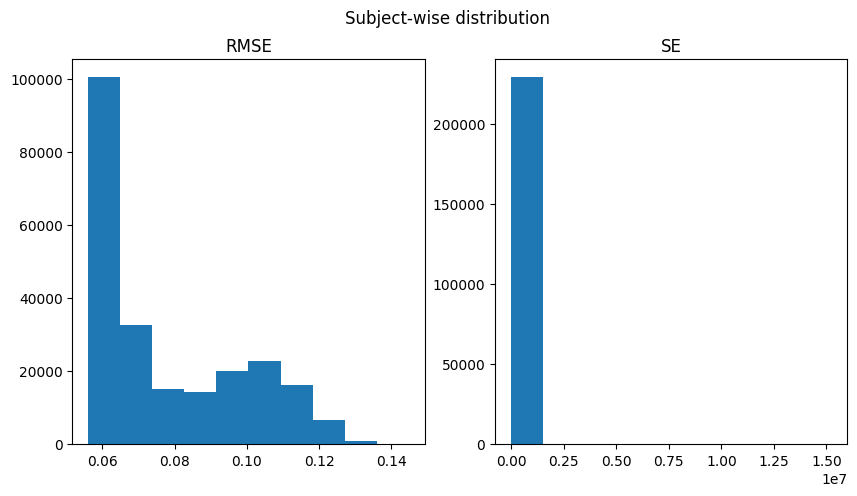

In [16]:
fig, axes = plt.subplots(ncols=2)
axes[0].hist(np.nanmean(roi_rts_rmse, axis=0))
axes[0].set_title('RMSE')

axes[1].hist(np.nanmean(roi_rts_se, axis=0))
axes[1].set_title('SE')
fig.suptitle('Subject-wise distribution')
fig.set_size_inches(10, 5)
plt.show()

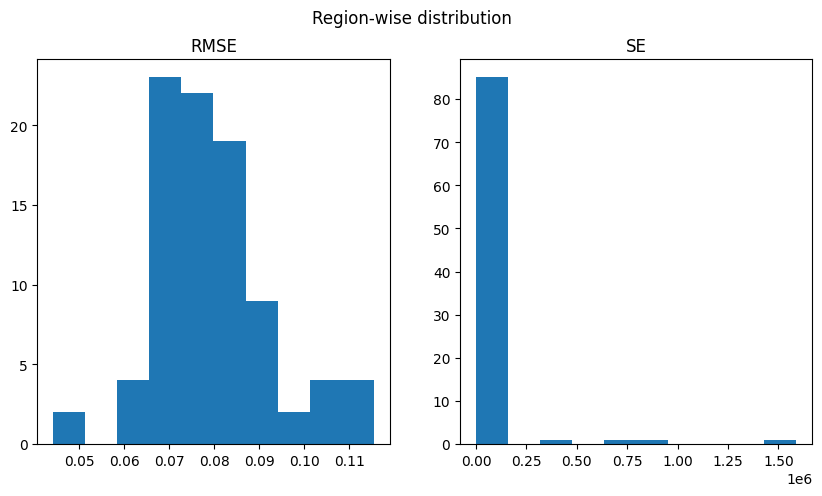

In [17]:
fig, axes = plt.subplots(ncols=2)
axes[0].hist(np.nanmean(roi_rts_rmse, axis=1))
axes[0].set_title('RMSE')

axes[1].hist(np.nanmean(roi_rts_se, axis=1))
axes[1].set_title('SE')

# axes[1].hist(np.mean(roi_rts_se, axis=1))
# axes[1].set_title('SE')
fig.suptitle('Region-wise distribution')
fig.set_size_inches(10, 5)

plt.show()

In [21]:
cn_roi_rts = np.array([ roi_rts_taus[i] for i in range(roi_rts_taus.shape[0]) if dloader.diag[i] == 0 ])
cn_subs = [dloader.subjects_list[i] for i in range(roi_rts_taus.shape[0]) if dloader.diag[i] == 0]
ad_roi_rts = np.array([ roi_rts_taus[i] for i in range(roi_rts_taus.shape[0]) if dloader.diag[i] == 1 ])
ad_subs = [dloader.subjects_list[i] for i in range(roi_rts_taus.shape[0]) if dloader.diag[i] == 1]
# np.save('results/cn_roi_rts', cn_roi_rts)
# np.save('results/ad_roi_rts', ad_roi_rts)

In [22]:
nan_rois = np.unique(np.where(np.isnan(roi_rts_taus))[1]).shape
print(f'ROIs with NaN values (for any subject): {115564/roi_rts_taus.shape[1] *100: .2f} %')

ROIs with NaN values (for any subject):  50.48 %


In [23]:
print(cn_roi_rts.shape, ad_roi_rts.shape)

(55, 228939) (34, 228939)


## Typical subjects

In [24]:
import nibabel as nib
from nilearn import image, plotting, datasets

In [25]:
anat_img = dloader.get_anat(dloader.subjects_list[25])
anat_data = anat_img.get_fdata()
func_img = dloader.get_func(dloader.subjects_list[25])

In [26]:
resampled_anat_img = image.resample_img(anat_img, target_affine=func_img.affine, target_shape=func_img.shape[:3])

In [27]:
def plot_voxels(sig_rois, resampled_anat_img, intensity=None, shape=(51, 67, 67), node_threshold=0.5):
    index = np.unravel_index(sig_rois, shape=shape)
    index = np.array(index)
    index = index.T
    if not intensity is None:
        intensity = (intensity - np.mean(intensity))/np.std(intensity)
    mni_coords = nib.affines.apply_affine(resampled_anat_img.affine, index)
    if intensity is None:
        plotting.plot_markers([1, ] * len(mni_coords), mni_coords)
    else:
        plotting.plot_markers(intensity, mni_coords, node_threshold=node_threshold, node_cmap='gray')
#     plotting.plot_markers([1, ], [ (0, 0, 0) ])

In [28]:
def find_group_typicals(rts, cn_rts_mean=None, n=1, shape=(51, 67, 67), alpha=1, node_threshold=0.5):
    rts_median = np.nanmedian(rts, axis=0)
    rts_mean = np.nanmean(rts, axis=0)
    rts_std = np.nanstd(rts, axis=0)
    if not cn_rts_mean is None:
        rts_mean = np.nanmean(cn_rts_mean, axis=0)
        rts_std = np.nanstd(cn_rts_mean, axis=0)
    del_taus = rts - rts_median
    del_taus_mean = np.nanmean(np.abs(del_taus), axis=1)
    sub_idx = np.argsort(del_taus_mean)[:n]
    for i in range(n):
        anat_img = dloader.get_anat(dloader.subjects_list[sub_idx[i]])
        func_img = dloader.get_func(dloader.subjects_list[sub_idx[i]])
        resampled_anat_img = image.resample_img(anat_img, target_affine=func_img.affine, target_shape=func_img.shape[:3])
        diff = rts[sub_idx[i]] - rts_mean
        sig_rois = list(np.where(np.abs(diff) > alpha*rts_std)[0])
        plot_voxels(sig_rois, resampled_anat_img, intensity=diff[sig_rois], shape=shape, node_threshold=node_threshold)
    return sub_idx, del_taus

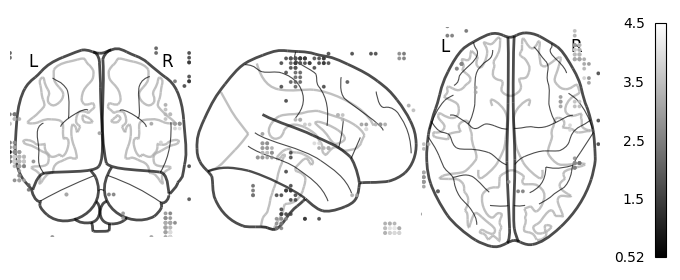

In [27]:
sub_idx, del_taus = find_group_typicals(ad_roi_rts, cn_rts_mean=cn_roi_rts, alpha=1, node_threshold=0.5)

In [28]:
del_taus[sub_idx]


array([[-0.1163795, -0.1163795, -0.1163795, ..., -0.1163795, -0.1163795,
        -0.1163795]], dtype=float32)

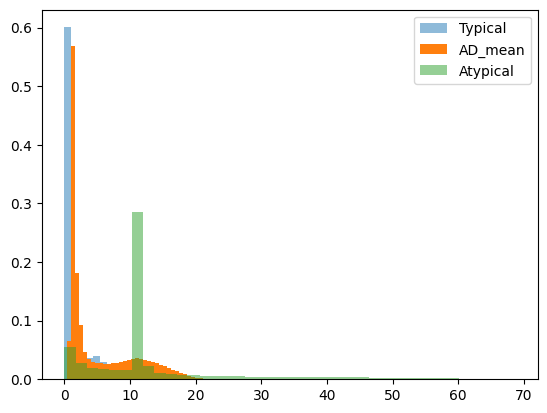

In [29]:
ad_roi_rts_mean = np.nanmean(ad_roi_rts, axis=0)
for i in sub_idx:
    plt.hist(ad_roi_rts[i], bins=40, density=True, alpha=0.5, label='Typical')
    plt.hist(ad_roi_rts_mean, bins=40, density=True, label='AD_mean')

    del_taus_mean = np.nanmean(np.abs(del_taus), axis=1)
    atyp = np.argsort(del_taus_mean)[-1]
    plt.hist(ad_roi_rts[atyp], bins=40, density=True, alpha=0.5, label='Atypical')
    plt.legend()
    plt.show()

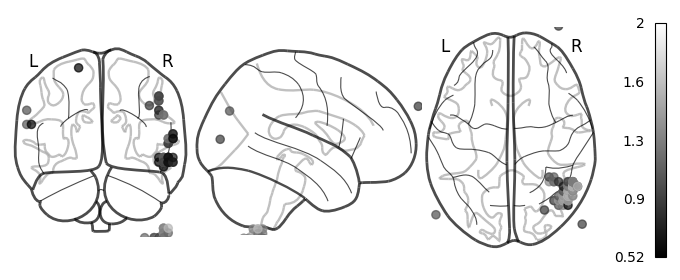

In [30]:
sub_idx = find_group_typicals(cn_roi_rts, alpha=2)

In [31]:
flat_func = func_img.get_fdata()
flat_func = flat_func.reshape((-1, flat_func.shape[-1]))
flat_func.shape

(228939, 200)

## Removing outlier taus

In [29]:
rrts = np.array(roi_rts_taus)
print(rrts.shape)
for i in range(rrts.shape[1]):
    rrts[np.isnan(rrts[:, i]), i] = np.nanmean(rrts[:, i])

(89, 228939)


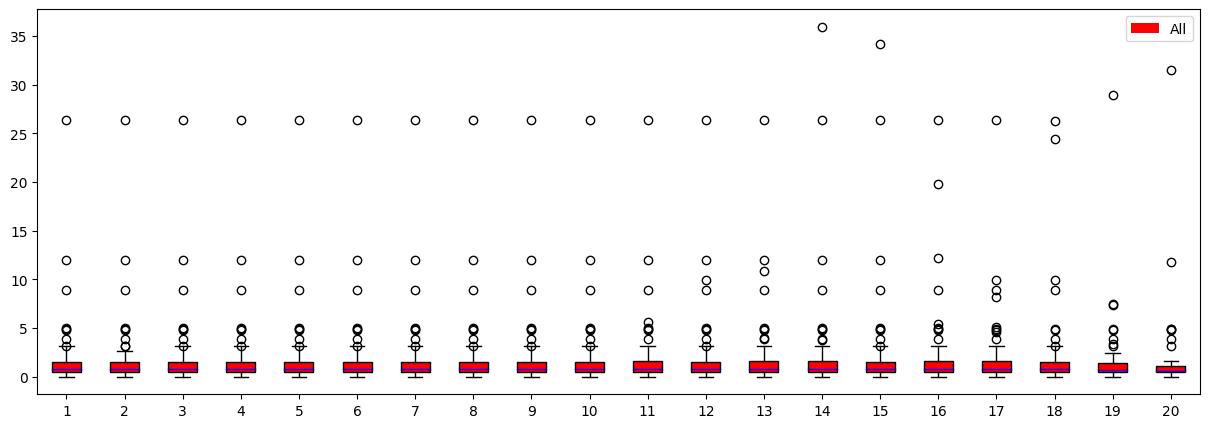

In [30]:
from matplotlib.patches import Patch

fig, ax = plt.subplots()

roi_start, roi_end = 1000, 1020
# bp1 = ax.boxplot(cn_roi_rts[:, sig_rois[:20]], patch_artist=True)
bp1 = ax.boxplot(np.array(rrts[:, roi_start:roi_end]), patch_artist=True)
# bp1 = ax.boxplot(np.array(cn_roi_rts[:, roi_start:roi_end]), patch_artist=True)
roi_start:roi_end

box_colors = ['red',]
median_colors = ['blue', ]
for bplot, box_color, median_color in zip([bp1,], box_colors, median_colors):
    # change box color
    for patch in bplot['boxes']:
        patch.set_facecolor(box_color)
    # change median color
    for line in bplot['medians']:
        line.set_color(median_color)
        
color_patches = [ Patch(facecolor=box_colors[0], label=f'All'), ]
ax.legend(handles=color_patches)
fig.set_size_inches(15, 5)
# plt.ylim(0, 10)

plt.show()

In [31]:
def get_accepted_ranges(rrts):
    accepted_ranges = []
    for roi_ind in range(rrts.shape[1]):
        q1, q3 = np.nanpercentile(rrts[:, roi_ind], [25, 75])

        # Calculate IQR
        iqr = q3 - q1

        # Calculate lower and upper bounds
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        accepted_ranges.append((lower_bound, upper_bound))
    accepted_ranges = np.array(accepted_ranges)

    return accepted_ranges

In [32]:
def get_outliers(rrts, accepted_ranges, sub_idxs=None):
    outliers = []
    for i in range(rrts.shape[1]):
        rejected_subs = np.where( (rrts[:, i] < accepted_ranges[i][0]) | (rrts[:, i] > accepted_ranges[i][1]) )[0]
        nan_subs = np.where(np.isnan(rrts[:, i]))[0]
        outliers.append(list(set(list(rejected_subs) + list(nan_subs))))
    
    # Popping elements not included in subject list without 
    # disturbing original indices
    if not (type(sub_idxs) == type(None)):
        for roi_ind in range(len(outliers)):
            non_sub_idx_outliers = []
            outliers[roi_ind] = list(outliers[roi_ind])

            for i in range(len(outliers[roi_ind])):
                if outliers[roi_ind][i] not in sub_idxs:
                    non_sub_idx_outliers.append(i)
            for i in sorted(non_sub_idx_outliers, reverse=True):
                del outliers[roi_ind][i]

    return outliers

In [34]:
ad_sub_idxs = [ i for i in range(len(dloader.subjects_list)) if dloader.diag[i] == 1 ]
cn_sub_idxs = [ i for i in range(len(dloader.subjects_list)) if dloader.diag[i] == 0 ]
len(ad_sub_idxs), len(cn_sub_idxs)

(34, 55)

In [35]:
ad_accepted_ranges = get_accepted_ranges(ad_roi_rts)
cn_accepted_ranges = get_accepted_ranges(cn_roi_rts)

In [36]:
ad_outliers = get_outliers(ad_roi_rts, ad_accepted_ranges)
cn_outliers = get_outliers(cn_roi_rts, cn_accepted_ranges)

ad_ind_outliers = get_outliers(roi_rts_taus, ad_accepted_ranges, ad_sub_idxs)
cn_ind_outliers = get_outliers(roi_rts_taus, cn_accepted_ranges, cn_sub_idxs)

In [38]:
outliers = []
for i in range(len(ad_ind_outliers)):
    outliers.append(ad_ind_outliers[i] + cn_ind_outliers[i])
    outliers[i].sort()
outliers

[[15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85, 87],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85, 87],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 51, 62, 63, 64, 85, 87],
 [15, 20, 24, 27, 31, 34, 39, 44, 45, 46, 5

In [56]:
# np.save('results/outliers.npy', outliers)
# np.save('results/accepted_ranges.npy', accepted_ranges)
# outliers = np.load('results/outliers.npy', allow_pickle=True)
# accepted_ranges = np.load('results/accepted_ranges.npy')

/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
# accepted_ranges = get_accepted_ranges(roi_rts_taus)
# outliers = get_outliers(roi_rts_taus, accepted_ranges)

### Checking outlier distribution

In [39]:
# outliers_diag_ad_count = [ len(np.array(i)[np.array(i) == 1]) for i in outliers_diag]
# outliers_diag_cn_count = [ len(np.array(i)[np.array(i) == 0]) for i in outliers_diag]
outliers_diag_ad_count = [ len(i) for i in ad_outliers ]
outliers_diag_cn_count = [ len(i) for i in cn_outliers ]
print(np.mean(outliers_diag_ad_count), np.mean(outliers_diag_cn_count))
print(np.sum(outliers_diag_ad_count), np.sum(outliers_diag_cn_count))

3.295493559419758 7.965969100939551
754467 1823721


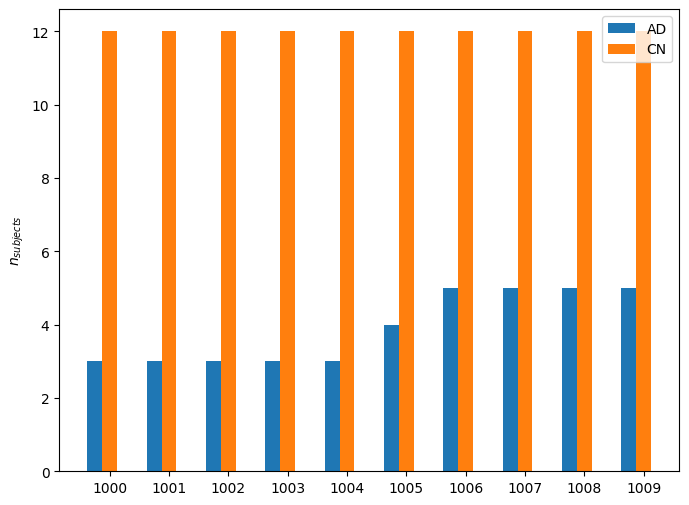

In [165]:
fig, ax = plt.subplots(figsize=(8, 6))

# Set the bar width
bar_width = 0.25

roi_start, roi_end = 1000, 1010
x_labels = list(range(roi_start, roi_end))

# Set the positions of the bars on the x-axis
x_pos_1 = np.arange(len(x_labels))
x_pos_2 = [x + bar_width for x in x_pos_1]
# x_pos_3 = [x + 2 * bar_width for x in x_pos_1]

# Plot the bars
ax.bar(x_pos_1, outliers_diag_ad_count[roi_start:roi_end], width=bar_width, label='AD')
ax.bar(x_pos_2, outliers_diag_cn_count[roi_start:roi_end], width=bar_width, label='CN')
# ax.bar(x_pos_3, y_data_3, width=bar_width, label='Group 3')

# Set the x-axis labels
ax.set_xticks([x + bar_width for x in range(len(x_labels))])
ax.set_xticklabels(x_labels)

# Set the y-axis label
ax.set_ylabel('$n_{subjects}$')

# Add a legend
ax.legend()

# Show the plot
plt.show()

### Fixing outliers

In [70]:
def fix_outliers(inp_rrts, outliers):
    '''
    Outputs array after setting all outliers and all NaNs to the mean values
    '''
    rrts = np.array(inp_rrts)
    
    for i in range(rrts.shape[1]):
        rrts[outliers[i], i] = np.nan
#     for i in range(rrts.shape[1]):
#         rrts[np.isnan(rrts[:, i]), i] = np.nanmean(rrts[:, i])
    return rrts

In [41]:
# Load everything

# np.save('results/rrts_fixed.npy', rrts_fixed)
# np.save('results/rrts_fixed_s.npy', rrts_fixed_s)
# rrts_fixed = np.load('results/rrts_fixed.npy')
# rrts_fixed.shape

NameError: name 'rrts_fixed' is not defined

In [71]:
rrts_fixed = fix_outliers(roi_rts_taus, outliers)
rrts_fixed.shape

(89, 228939)

In [72]:
rrts_fixed_s = rrts_fixed.reshape((rrts_fixed.shape[0], *og_shape,))
rrts_fixed_s.shape

(89, 51, 67, 67)

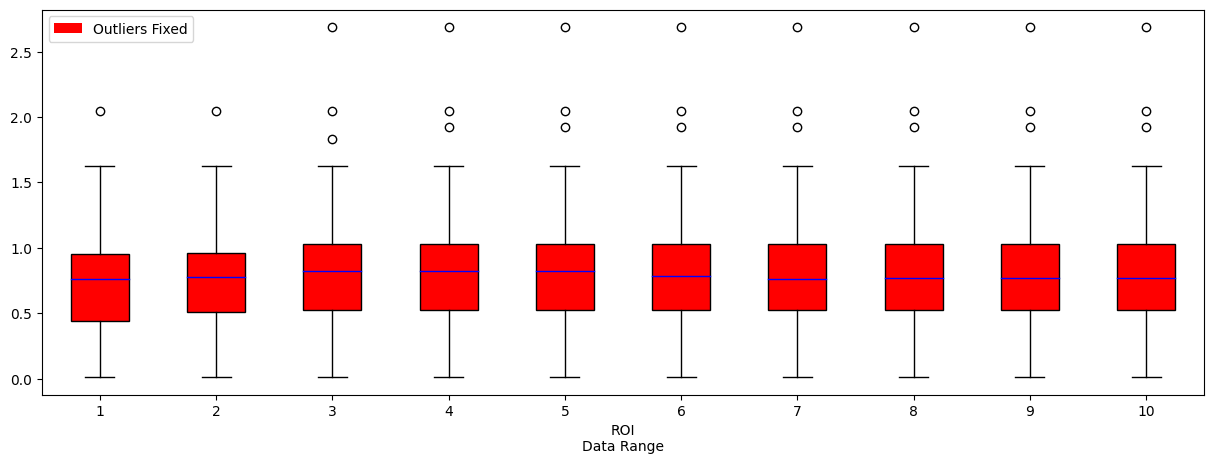

In [53]:
from matplotlib.patches import Patch

fig, ax = plt.subplots()

roi_start, roi_end = 1000, 1010
# bp1 = ax.boxplot(cn_roi_rts[:, sig_rois[:20]], patch_artist=True)
bp1 = ax.boxplot(np.array(f_cn_roi_rts[:, roi_start:roi_end]), patch_artist=True)
# bp1 = ax.boxplot(np.array(cn_roi_rts[:, roi_start:roi_end]), patch_artist=True)

box_colors = ['red',]
median_colors = ['blue', ]
for bplot, box_color, median_color in zip([bp1,], box_colors, median_colors):
    # change box color
    for patch in bplot['boxes']:
        patch.set_facecolor(box_color)
    # change median color
    for line in bplot['medians']:
        line.set_color(median_color)
        
color_patches = [ Patch(facecolor=box_colors[0], label=f'Outliers Fixed'), ]
ax.legend(handles=color_patches)
fig.set_size_inches(15, 5)

# xticks = [ f"{i}\n{accepted_ranges[i][0]:.2f},{accepted_ranges[i][1]:.2f}" for i in range(roi_start, roi_end) ]
# plt.xticks(range(1, roi_end-roi_start+1), xticks)
# plt.ylim(0, 10)
plt.xlabel("ROI\nData Range")

plt.show()

In [49]:
indices = np.random.permutation(len(f_cn_roi_rts))
split_idx = int(len(f_cn_roi_rts) * 0.5) # splitting the array in half
spl1 = f_cn_roi_rts[indices[:split_idx]]
spl2 = f_cn_roi_rts[indices[split_idx:]]

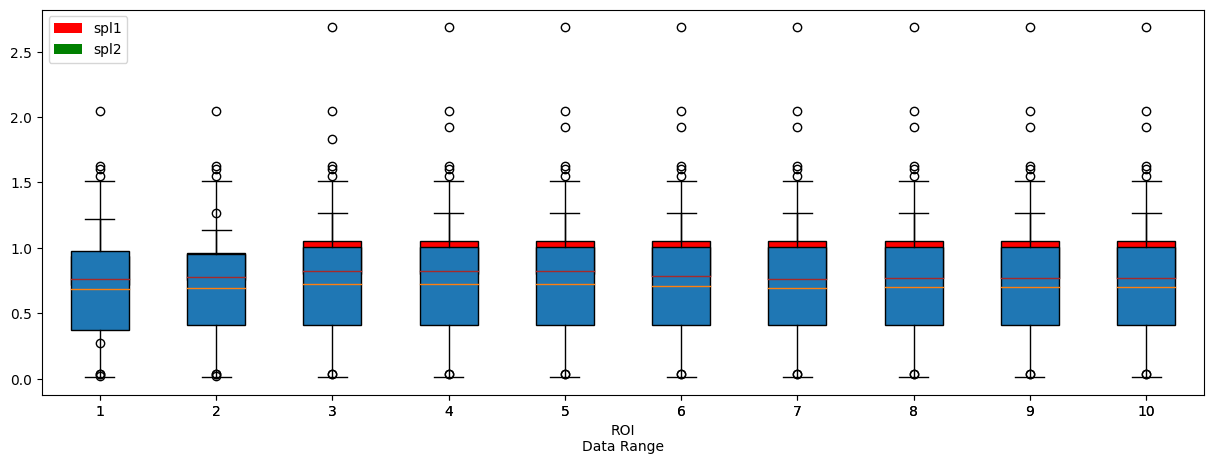

In [52]:

fig, ax = plt.subplots()

# roi_start, roi_end = 1000, 1010
# bp1 = ax.boxplot(cn_roi_rts[:, sig_rois[:20]], patch_artist=True)
bp1 = ax.boxplot(np.array(spl1[:, roi_start:roi_end]), patch_artist=True)
bp2 = ax.boxplot(np.array(spl2[:, roi_start:roi_end]), patch_artist=True)

box_colors = ['red', 'green', ]
median_colors = ['brown', 'blue' ]
for bplot, box_color, median_color in zip([bp1,], box_colors, median_colors):
    # change box color
    for patch in bplot['boxes']:
        patch.set_facecolor(box_color)
    # change median color
    for line in bplot['medians']:
        line.set_color(median_color)
        
color_patches = [ 
    Patch(facecolor=box_colors[0], label=f'spl1'), 
    Patch(facecolor=box_colors[1], label=f'spl2'), 
]
ax.legend(handles=color_patches)
fig.set_size_inches(15, 5)

# xticks = [ f"{i}\n{accepted_ranges[i][0]:.2f},{accepted_ranges[i][1]:.2f}" for i in range(roi_start, roi_end) ]
# plt.xticks(range(1, roi_end-roi_start+1), xticks)
# plt.ylim(0, 10)
plt.xlabel("ROI\nData Range")

plt.show()

##  P-Test

In [73]:
f_roi_rts_taus = rrts_fixed

In [74]:
def get_kfold_inds(max_ind, fold=0, max_fold=2):
#     kfold_ind = np.floor(np.array([ i * max_fold for i in range(max_fold) ]))[fold]
#     kfold_ind = [ 0 * len(indices)/max_fold ]
#     print(kfold_ind)
    kfold_ind = np.linspace(0, max_ind, max_fold+1)[fold]
    return int(kfold_ind)

In [75]:
def get_kfold(data, fold=0, max_fold=2):
    start_ind = get_kfold_inds(len(data), fold, max_fold)
    end_ind = get_kfold_inds(len(data), fold+1, max_fold)
    return data[start_ind:end_ind]

In [76]:
f_cn_roi_rts = np.array([ f_roi_rts_taus[i] for i in range(f_roi_rts_taus.shape[0]) if dloader.diag[i] == 0 ])
f_ad_roi_rts = np.array([ f_roi_rts_taus[i] for i in range(f_roi_rts_taus.shape[0]) if dloader.diag[i] == 1 ])
f_cn_roi_rts.shape, f_ad_roi_rts.shape

((55, 228939), (34, 228939))

In [502]:
# split the array using the random indices
indices = np.random.permutation(len(f_cn_roi_rts))
split_idx = int(len(f_cn_roi_rts) * 0.5) # splitting the array in half
spl1 = f_cn_roi_rts[indices[:split_idx]]
spl2 = f_cn_roi_rts[indices[split_idx:]]

# spl1 = f_cn_roi_rts
# spl2 = f_ad_roi_rts

# mean_tau = np.nanmean(f_roi_rts_taus)
# split1[np.isnan(split1)] = mean_tau
# split2[np.isnan(split2)] = mean_tau
# cn_roi_rts_mean = np.nanmean(cn_roi_rts, axis=0)
# ad_roi_rts_mean = np.nanmean(ad_roi_rts, axis=0)
# cn_roi_rts_mean = np.nanmean(split1, axis=0)
# ad_roi_rts_mean = np.nanmean(split2, axis=0)
# split1 = cn_roi_rts
# split2 = ad_roi_rts

In [503]:
spl1_ar = get_accepted_ranges(spl1)
spl2_ar = get_accepted_ranges(spl2)

In [504]:
spl1_outliers = get_outliers(spl1, spl1_ar)
spl2_outliers = get_outliers(spl2, spl2_ar)

In [505]:
spl1.shape, spl2.shape

((27, 228939), (28, 228939))

In [506]:
import scipy.stats as stats
# t_stat, p_value = stats.ttest_ind(split1, split2)

t_stat, p_value = [], []
spl1_roi_rts_mean, spl2_roi_rts_mean = [], []
spl1_roi_rts_std, spl2_roi_rts_std = [], []
roi_rts_mean, roi_rts_std = [], []
for roi_ind in range(f_roi_rts_taus.shape[1]):
    
    spl1_accepted_subs = list(set(range(len(spl1))).difference(spl1_outliers[roi_ind]))
    spl2_accepted_subs = list(set(range(len(spl2))).difference(spl2_outliers[roi_ind]))
#     ad_accepted_subs = list(set(range(len(ad_roi_rts))).difference(ad_outliers[roi_ind]))
#     cn_accepted_subs = list(set(range(len(cn_roi_rts))).difference(cn_outliers[roi_ind]))

        
    split1 = spl1[spl1_accepted_subs, roi_ind]
    split2 = spl2[spl2_accepted_subs, roi_ind]
#     split1 = ad_roi_rts[ad_accepted_subs, roi_ind]
#     split2 = cn_roi_rts[cn_accepted_subs, roi_ind]

    spl1_roi_rts_mean.append(np.mean(split1)), spl2_roi_rts_mean.append(np.mean(split2))
    spl1_roi_rts_std.append(np.std(split1)), spl2_roi_rts_std.append(np.std(split2))
    roi_rts_mean.append(np.mean(np.concatenate([split1, split2])))
    roi_rts_std.append(np.std(np.concatenate([split1, split2])))
    
    t, p = stats.ttest_ind(split1, split2)
    t_stat.append(t), p_value.append(p)
    
    if roi_ind%10000 == 0:
        print(roi_ind, end=" ")

spl1_roi_rts_mean = np.array(spl1_roi_rts_mean)
spl2_roi_rts_mean = np.array(spl2_roi_rts_mean)
spl1_roi_rts_std = np.array(spl1_roi_rts_std)
spl2_roi_rts_std = np.array(spl2_roi_rts_std)
roi_rts_mean = np.array(roi_rts_mean)
roi_rts_std = np.array(roi_rts_std)

p_value = np.array(p_value)
t_stat = np.array(t_stat)

# Print the results
print("t-statistic: ", t_stat)
print("p-value: ", p_value)

0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 t-statistic:  [-0.12272873 -0.12272873 -0.12272873 ... -0.12272873 -0.12272873
 -0.12272873]
p-value:  [0.90293648 0.90293648 0.90293648 ... 0.90293648 0.90293648 0.90293648]


In [496]:
# t1 = spl1_roi_rts_mean
# t2 = spl2_roi_rts_mean
# t3 = roi_rts_std
# t4 = spl1_roi_rts_std
# t5 = spl2_roi_rts_std
# t6 = roi_rts_mean
# np.savez("ad-cn-split.npz", t1=t1, t2=t2, t3=t3, t4=t4, t5=t5, t6=t6)

In [508]:
cn1 = spl1_roi_rts_mean
cn2 = spl2_roi_rts_mean
cn3 = roi_rts_std
cn4 = spl1_roi_rts_std
cn5 = spl2_roi_rts_std
cn6 = roi_rts_mean
np.savez("cn-cn-split.npz", t1=cn1, t2=cn2, t3=cn3, t4=cn4, t5=cn5, t6=cn6)

In [501]:
cn3.shape

(228939,)

In [497]:
sr = np.where( ( np.abs(t1 - t2) > 2 * np.abs(t4) ) & (t4 < 3) )[0]
print("Significant regions based on mean diff: \n", len(sr))

Significant regions based on mean diff: 
 2664


In [488]:
sr = np.where( ( np.abs(spl1_roi_rts_mean - spl2_roi_rts_mean) > 2*np.abs(roi_rts_std) ) & (roi_rts_std < 3) )[0]
print("Significant regions based on mean diff: \n", len(sr))

Significant regions based on mean diff: 
 0


- AD-CN split: 8118 / 17817 regions; 16559 for 0.005 p-val
- Random CN split: 19029 / 8323 regions; 8323 for 0.005 p-val
- Random CN split 2: 8847 / 12077 regions; 4074 for 0.005 p-val 
- Random CN split 3: 4629 / 23544 regions; 9747 for 0.005 p-val
- Random CN split 4: 12237 regions;
- Random CN split (2*sigma): 2328 / 4124 regions; 
- AD-CN split (2*sigma): 2777 / 5451 regions;

#### Results
- Random CN split (1*sigma): 815 regions
- AD-CN split (1*sigma): 81 (<3) regions; 212 overall regions
- AD-CN split (2*sigma): 2664 (<3) regions (CN sigma)
#### -----------

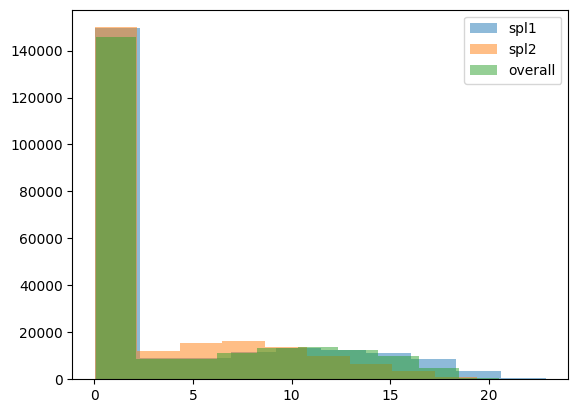

In [466]:
plt.hist(spl1_roi_rts_std, label='spl1', alpha=.5)
plt.hist(spl2_roi_rts_std, label='spl2', alpha=.5)
plt.hist(roi_rts_std, label='overall', alpha=0.5)
plt.legend()

(array([1.52546e+05, 1.40240e+04, 1.59760e+04, 1.54300e+04, 1.30360e+04,
        9.05600e+03, 5.66100e+03, 2.67700e+03, 4.88000e+02, 4.50000e+01]),
 array([ 0.32849789,  2.78059602,  5.23269415,  7.68479252, 10.13689041,
        12.58898926, 15.04108715, 17.49318504, 19.94528389, 22.39738083,
        24.84947968]),
 <BarContainer object of 10 artists>)

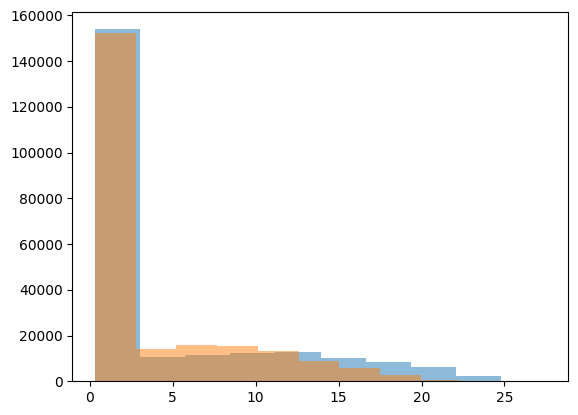

In [467]:
plt.hist(spl1_roi_rts_mean, label='spl1', alpha=.5)
plt.hist(spl2_roi_rts_mean, label='spl2', alpha=.5)

In [421]:
cn_roi_rts_mean = spl1_roi_rts_mean
ad_roi_rts_mean = spl2_roi_rts_mean
cn_roi_rts_mean.shape, ad_roi_rts_mean.shape

((228939,), (228939,))

In [422]:
np.mean(p_value), np.std(p_value)

(0.34522922061669065, 0.2654062201948075)

In [345]:
print("NaNs in p-value:", len(p_value[np.isnan(p_value)]))
print("Percentage of NaNs:", np.isnan(p_value).sum()/len(p_value) *100)

NaNs in p-value: 0
Percentage of NaNs: 0.0


In [346]:
low_sig_rois = list(np.where(p_value > 0.95)[0])
len(low_sig_rois)

4929

In [454]:
sig_rois = list(np.where(p_value < 0.005)[0])
print("Significant RoIs:", len(sig_rois))

Significant RoIs: 6560


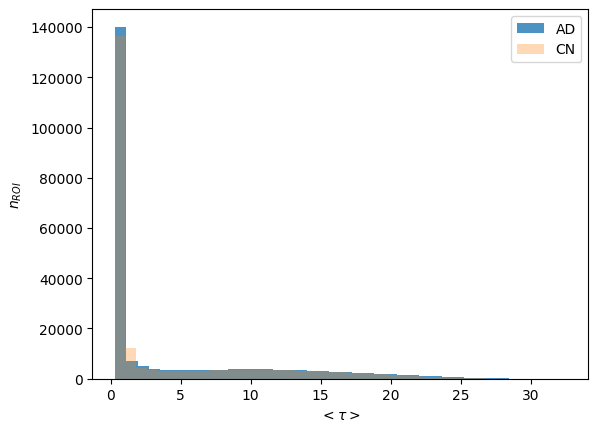

In [348]:
plt.hist(spl1_roi_rts_mean, label='AD', alpha=0.8, bins=40)
plt.hist(spl2_roi_rts_mean, label='CN', alpha=0.3, bins=40)
plt.legend()
plt.xlabel("$<\\tau>$")
plt.ylabel("$n_{ROI}$")
plt.show()

#### Plotting for overlap regions  (temp)

In [349]:
lower_lim, upper_lim = 4, 8
spl1w = np.where((spl1_roi_rts_mean > lower_lim) & (spl1_roi_rts_mean < upper_lim))[0]
spl2w = np.where((spl2_roi_rts_mean > lower_lim) & (spl2_roi_rts_mean < upper_lim))[0]
spl2w = np.where(spl2_roi_rts_mean > 15)[0]
overlap_regions = list(set(spl1w).intersection(set(spl2w)))
overlap_regions.sort()

In [357]:
overlap_regions = sig_rois

In [200]:
spl1_p = np.array(spl1)
for i in range(spl1_p.shape[1]):
    spl1_p[:, i][np.where(np.isnan(spl1_p[:, i]))[0]] = np.nanmean(spl1_p[:, i])

spl2_p = np.array(spl2)
for i in range(spl2_p.shape[1]):
    spl2_p[:, i][np.where(np.isnan(spl2_p[:, i]))[0]] = np.nanmean(spl2_p[:, i])

In [221]:
np.nanmean(np.concatenate([ spl1[:, sr[roi_ind]], spl2[:, sr[roi_ind]] ]))

0.48176128

In [319]:
sr[40]

18858

In [358]:
dists = []
for i in range(len(sig_rois)):
    dist = spl1[:, sig_rois[i]]
    dists.append(dist - np.mean(dist))

In [359]:
dists = np.array(dists)
dists.shape

(4498, 27)

(array([  2.,  13.,  31., 123., 371., 356., 120.,  45.,  10.,   4.]),
 array([-4.73305045e-06, -3.79703670e-06, -2.86102295e-06, -1.92500943e-06,
        -9.88995680e-07, -5.29819317e-08,  8.83031760e-07,  1.81904545e-06,
         2.75505909e-06,  3.69107283e-06,  4.62708658e-06]),
 <BarContainer object of 10 artists>)

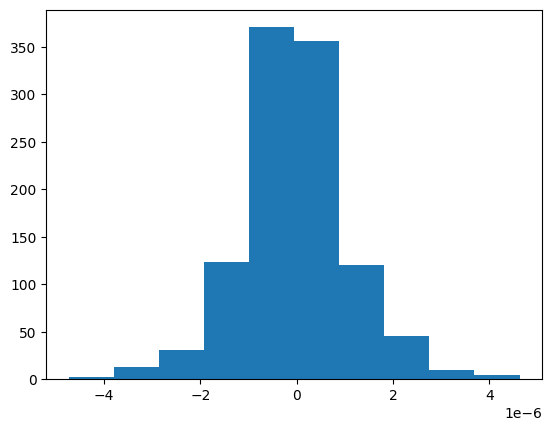

In [360]:
# for dist in dists:
# plt.plot(dists.shape[0], np.mean(dists, axis=1))
plt.hist(np.mean(dists, axis=1))

In [362]:
sr = sig_rois

In [405]:
spl1.shape

(27, 228939)

In [409]:
np.abs(spl1_roi_rts_mean[sr[roi_ind]] - spl2_roi_rts_mean[sr[roi_ind]]), \
np.abs(spl2_roi_rts_std[sr[roi_ind]])

(0.13488963, 0.09034943)

In [406]:
np.abs(spl1_roi_rts_mean[sr[roi_ind]] - spl2_roi_rts_mean[sr[roi_ind]]) < np.abs(spl1_roi_rts_std[sr[roi_ind]])a

True

In [374]:
def get_cdf(data):
    cdf = [ data[0] ]
    for i in data[1:]:
        cdf.append(i + cdf[-1])
    return cdf

Text(0.5, 1.0, '$\\tau$ Distribution for Region 12243')

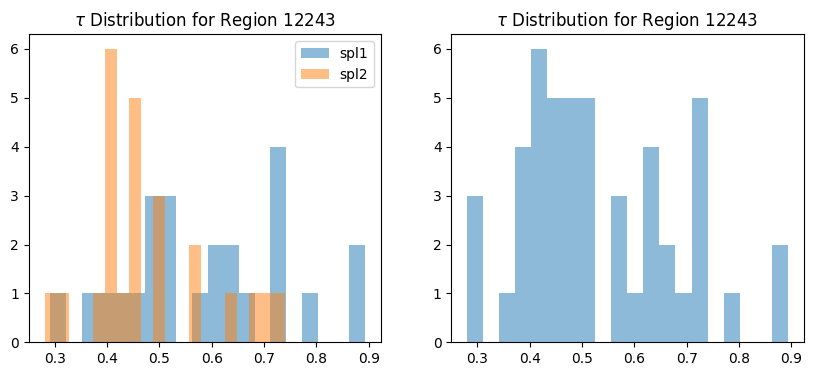

In [380]:
roi_ind = 123
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
hist1 = axs[0].hist(spl1[:, sr[roi_ind]], label='spl1', alpha=0.5, bins=20)
axs[0].hist(spl2[:, sr[roi_ind]], label='spl2', alpha=0.5, bins=20)
hist2 = axs[1].hist(np.concatenate([ spl1[:, sr[roi_ind]], spl2[:, sr[roi_ind]] ]), label='spl1', alpha=0.5, bins=20)
axs[0].legend()
axs[0].set_title(f"$\\tau$ Distribution for Region {sr[roi_ind]}")
axs[1].set_title(f"$\\tau$ Distribution for Region {sr[roi_ind]}")

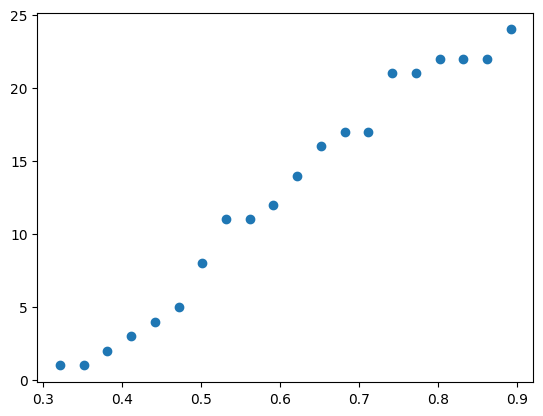

In [394]:
cdf = get_cdf(hist1[0])
plt.scatter(hist1[1][1:], cdf)

In [393]:
hist1

(array([1., 0., 1., 1., 1., 1., 3., 3., 0., 1., 2., 2., 1., 0., 4., 0., 1.,
        0., 0., 2.]),
 array([0.29161122, 0.32166129, 0.35171136, 0.38176143, 0.41181147,
        0.44186154, 0.47191161, 0.50196165, 0.53201175, 0.56206179,
        0.59211189, 0.62216192, 0.65221202, 0.68226206, 0.7123121 ,
        0.7423622 , 0.77241224, 0.80246234, 0.83251238, 0.86256248,
        0.89261252]),
 <BarContainer object of 20 artists>)

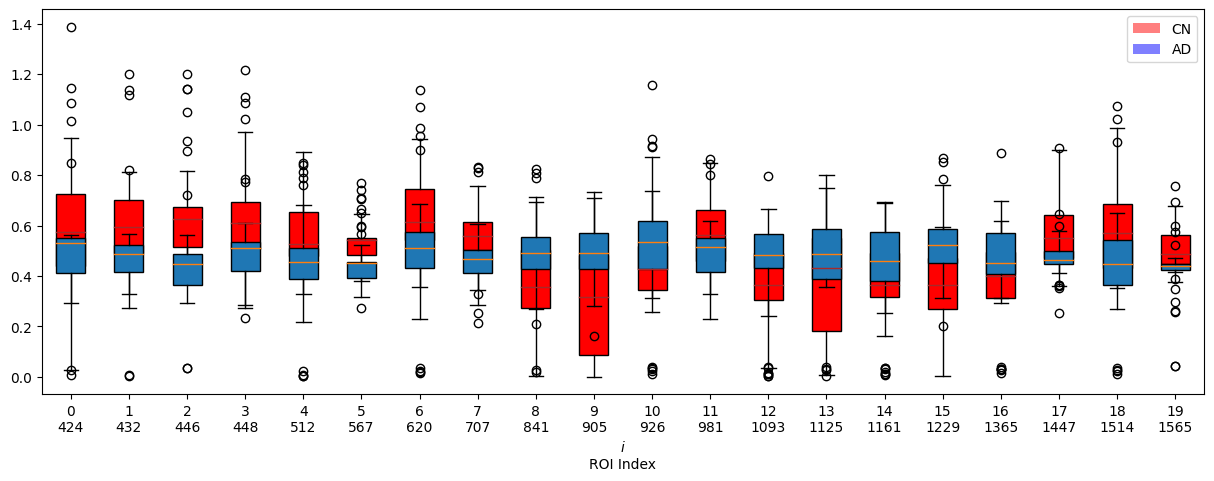

In [203]:

fig, ax = plt.subplots()

ind_start, ind_end = 0, 20
# bp1 = ax.boxplot(cn_roi_rts[:, sig_rois[:20]], patch_artist=True)
bp1 = ax.boxplot(spl1_p[:, overlap_regions[ind_start:ind_end]], patch_artist=True)
bp2 = ax.boxplot(spl2_p[:, overlap_regions[ind_start:ind_end]], patch_artist=True)

box_colors = ['red', 'blue', ]
median_colors = ['brown', 'green' ]
for bplot, box_color, median_color in zip([bp1,], box_colors, median_colors):
    # change box color
    for patch in bplot['boxes']:
        patch.set_facecolor(box_color)
    # change median color
    for line in bplot['medians']:
        line.set_color(median_color)
        
color_patches = [ 
    Patch(facecolor=box_colors[0], label=f'CN', alpha=0.5), 
    Patch(facecolor=box_colors[1], label=f'AD', alpha=0.5), 
]
ax.legend(handles=color_patches)
fig.set_size_inches(15, 5)

xticks = [ f"{i}\n{overlap_regions[i]}" for i in range(ind_start, ind_end) ]
plt.xticks(range(1, ind_end-ind_start+1), xticks)
# plt.ylim(0, 10)
plt.xlabel("$i$\nROI Index")

plt.show()

#### Temp end

In [89]:
print(np.mean(spl1_roi_rts_mean), np.mean(spl2_roi_rts_mean))
print(np.std(spl1_roi_rts_mean), np.std(spl2_roi_rts_mean))

4.554979 3.6777744
6.139795 4.7527227


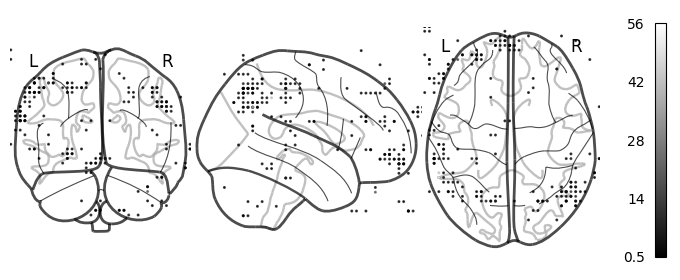

In [83]:
# plotting.plot_markers([1]*len(mni_coords.T), mni_coords.T)
intensity = 1/p_value[sig_rois]
intensity = (intensity - np.mean(intensity))/np.std(intensity)
plotting.plot_markers(intensity, mni_coords, node_threshold=0.5, node_cmap='gray')
# plotting.plot_markers(p_value[sig_rois, [[0,0,0]])

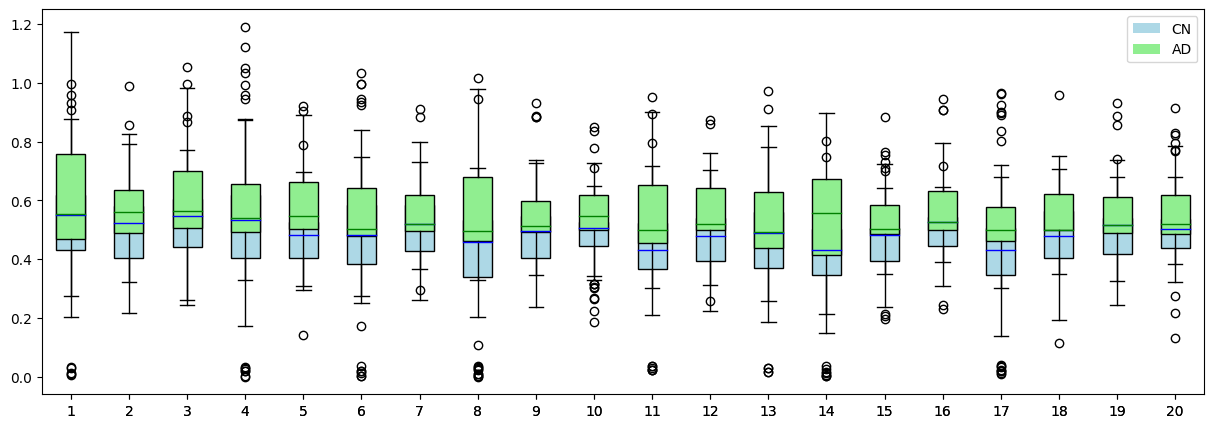

In [127]:
from matplotlib.patches import Patch

fig, ax = plt.subplots()

roi_start, roi_end = 75, 110
bp1 = ax.boxplot(f_cn_roi_rts[:, sig_rois[:20]], patch_artist=True)
bp2 = ax.boxplot(f_ad_roi_rts[:, sig_rois[:20]], patch_artist=True)

box_colors = ['lightblue', 'lightgreen']
median_colors = ['blue', 'green']
for bplot, box_color, median_color in zip([bp1, bp2], box_colors, median_colors):
    # change box color
    for patch in bplot['boxes']:
        patch.set_facecolor(box_color)
    # change median color
    for line in bplot['medians']:
        line.set_color(median_color)
        
color_patches = [ Patch(facecolor=box_colors[0], label=f'CN'), Patch(facecolor=box_colors[1], label=f'AD') ]
ax.legend(handles=color_patches)
fig.set_size_inches(15, 5)
# plt.show()

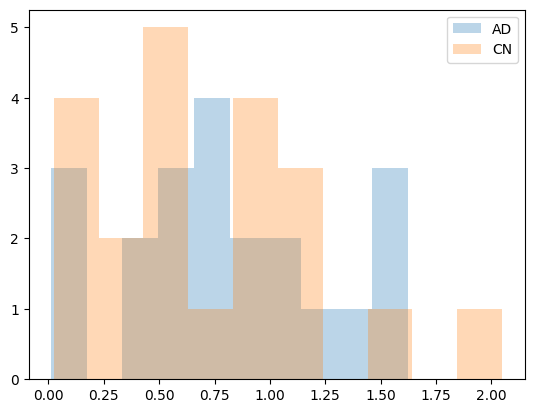

In [232]:
# Histogram for tau distribution for region 
roi_idx = 82
plt.hist(spl1[:, roi_idx], label='AD', alpha=0.3)
plt.hist(spl2[:, roi_idx], label='CN', alpha=0.3)
plt.legend()
plt.show()

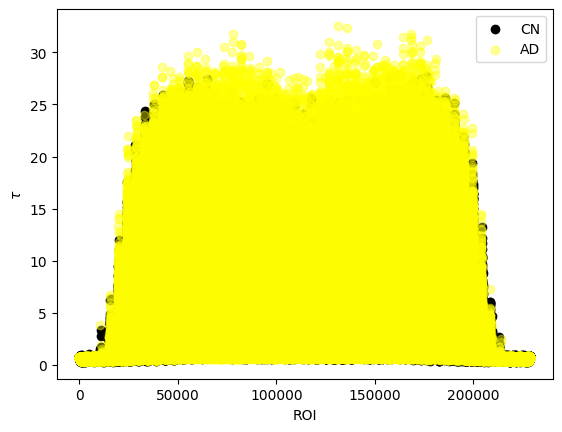

In [233]:
# Tau distribution over ROIs (averaged over subject) 
plt.scatter(range(len(cn_roi_rts_mean)), cn_roi_rts_mean, label='CN', color='black', alpha=1)
plt.scatter(range(len(ad_roi_rts_mean)), ad_roi_rts_mean, label='AD', color='yellow', alpha=0.4)
plt.ylabel('$\\tau$')
plt.xlabel('ROI')
# plt.axhline(y=np.nanmean(cn_roi_rts_mean))
plt.legend()

## Self-averaging calculation

In [21]:
ts = dloader.get_func(12).get_fdata()

In [22]:
def exp_fn(x, a, b):
    return a * np.power(x, -b)

In [23]:
def get_rx(ts):
    rx = np.var(ts) / np.power(np.mean(ts), 2)
    return rx

In [24]:
def get_avg_ts(ts, avg_level=1):
    new_ts = []
    
    for i in range(avg_level, ts.shape[0]-avg_level, 2*avg_level):
        ts_i = []
        for j in range(avg_level, ts.shape[1]-avg_level, 2*avg_level):
            ts_j = []
            for k in range(avg_level, ts.shape[2]-avg_level, 2*avg_level):
                avg_ts_ijk = np.mean(
                    ts[
                        i-avg_level:i+avg_level, 
                        j-avg_level:j+avg_level, 
                        k-avg_level:k+avg_level], 
                    axis=(0, 1, 2)
                )
                ts_j.append(avg_ts_ijk)
            ts_i.append(ts_j)
        new_ts.append(ts_i)
    new_ts = np.array(new_ts)
    return new_ts


In [25]:
def get_sub_rxs(ts, grains=[ 1, 2, 3, 4, 5, 7, 10, 15 ]):
    rxs = []
#     grains = [ 1, 2, 3, 4, 5, 7, 10, 15 ]
    for g in grains:
        nts = get_avg_ts(ts, g)
        rxs.append(get_rx(nts))
    return np.array(rxs)

In [34]:
grains = [ 1, 2, 3, 4, 5, 7, 10, 15 ]

In [42]:
grains = [ 1, 2, 3, 4, 5, 7, 10, 15 ]
fit_res = []
rxs = []
for i, sub in enumerate(dloader.subjects_list):
    ts = dloader.get_func(sub).get_fdata()
    rx = get_sub_rxs(ts, grains)
    rxs.append(rx)
    rx_log = np.log(rx)
    grains_log = np.log(grains)
    fit_res.append(np.polyfit(grains_log[:4], rx_log[:4], 1))
    print(f"{i}: Done with {sub}")

0: Done with 002_S_0295
1: Done with 002_S_0413
2: Done with 002_S_1261
3: Done with 002_S_1280
4: Done with 002_S_4213
5: Done with 002_S_4225
6: Done with 002_S_4262
7: Done with 002_S_4264
8: Done with 002_S_4270
9: Done with 002_S_5018
10: Done with 006_S_0498
11: Done with 006_S_0731
12: Done with 006_S_4150
13: Done with 006_S_4153
14: Done with 006_S_4192
15: Done with 006_S_4357
16: Done with 006_S_4449
17: Done with 006_S_4485
18: Done with 006_S_4546
19: Done with 006_S_4867
20: Done with 010_S_4345
21: Done with 010_S_4442
22: Done with 010_S_5163
23: Done with 012_S_4026
24: Done with 012_S_4545
25: Done with 012_S_4643
26: Done with 013_S_4579
27: Done with 013_S_4580
28: Done with 013_S_4616
29: Done with 013_S_4731
30: Done with 013_S_5071
31: Done with 018_S_4257
32: Done with 018_S_4313
33: Done with 018_S_4349
34: Done with 018_S_4399
35: Done with 018_S_4400
36: Done with 018_S_4696
37: Done with 018_S_4733
38: Done with 018_S_5074
39: Done with 018_S_5240
40: Done w

In [26]:
# np.save('results/rxs', rxs)
# np.save('results/fit_res', fit_res)

In [27]:
rxs = np.load('results/rxs.npy')
fit_res = np.load('results/fit_res.npy')

In [35]:
fit_res.shape

(89, 2)

In [30]:
np.mean(fit_res[:, 0])

-1.9215337764083922

In [97]:
# p0 = [ 1, 1, ]
# # p0 = [ 1, 0 ]
# popt, pcov = curve_fit(exp_fn, grains, rxs, p0=p0)

In [100]:
fit_res = np.polyfit(grains_log[4:], rxs_log[4:], 1)
fit_res

array([-2.10431952,  4.83838576])

slope: -0.2235305149912619


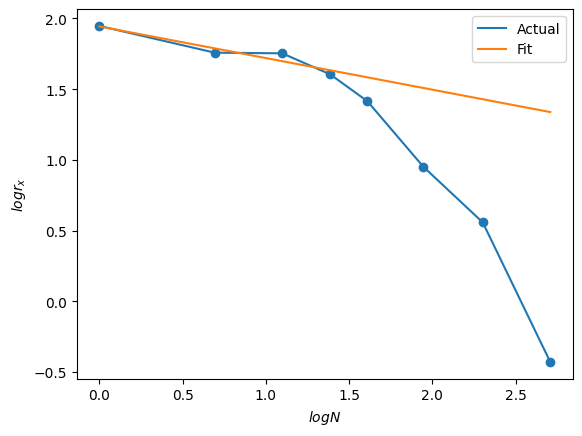

slope: -0.21953374675793252


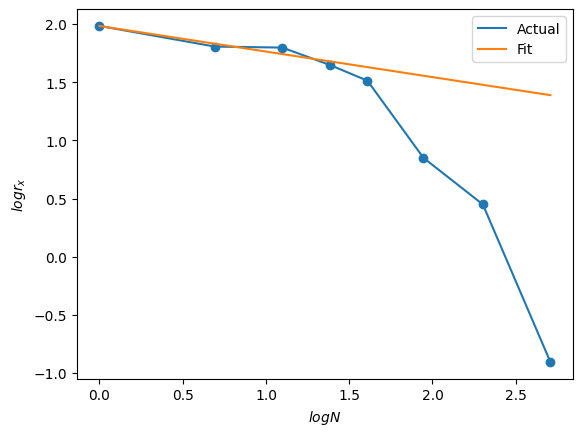

slope: -0.23054898392415188


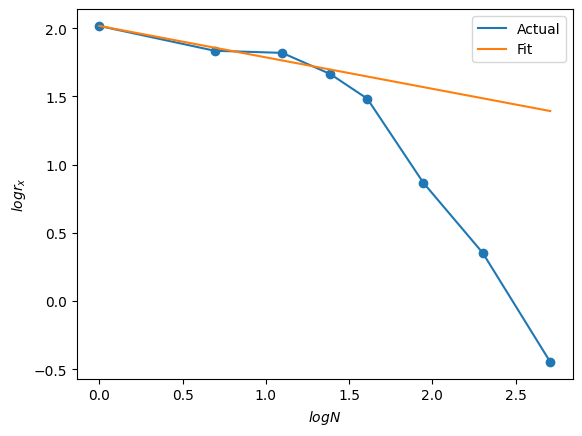

slope: -0.2188922773678216


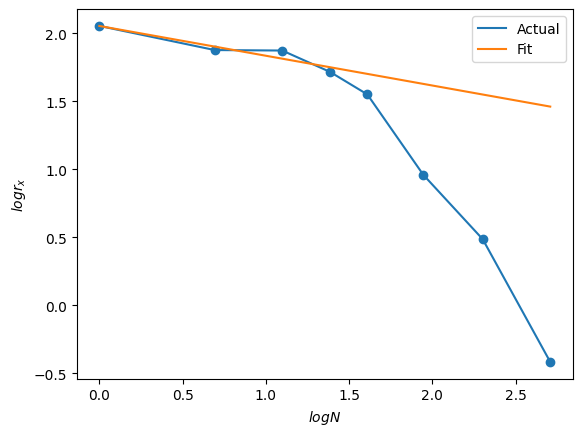

slope: -0.2441336011593762


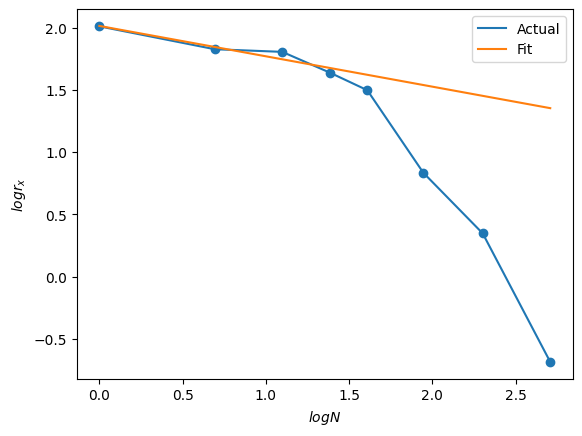

slope: -0.23179124407773244


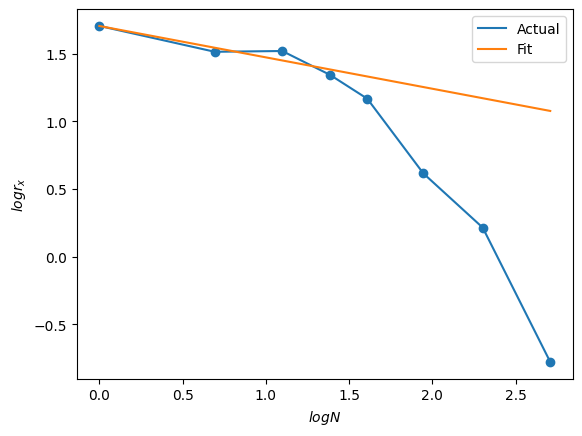

slope: -0.2184267573015068


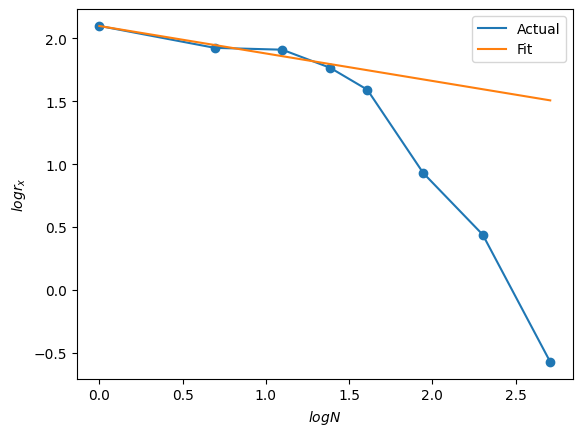

slope: -0.2405505161298684


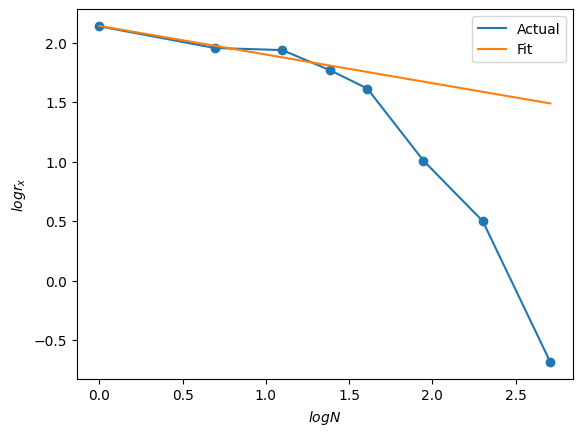

slope: -0.22515560642434046


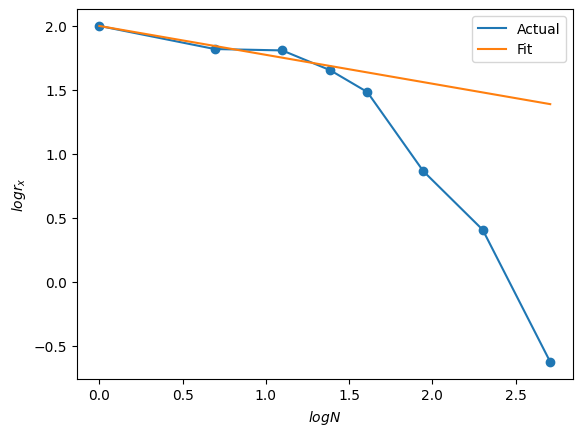

slope: -0.2425088277989696


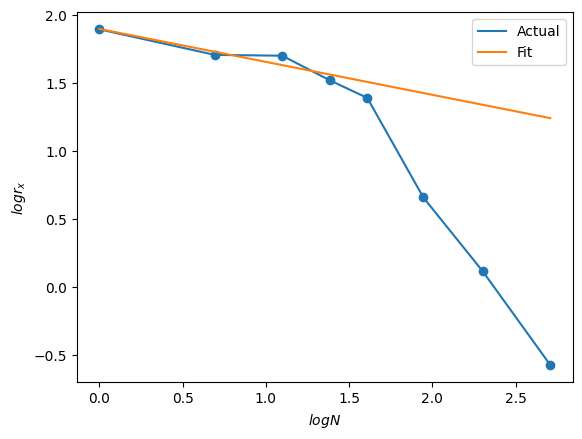

In [41]:
sub_ind = 2

for sub_ind in range(10):
    rx_log = np.log(rxs[sub_ind])
    grains_log = np.log(grains)
    plt.plot(grains_log, rx_log, label="Actual")
    plt.scatter(grains_log, rx_log)
    plt.plot(grains_log, [ fit_res[sub_ind][0]*i + fit_res[sub_ind][1] for i in grains_log ], label='Fit')
    plt.legend()
    plt.xlabel("$log N$")
    plt.ylabel("$log r_x$")
    print(f"slope: {fit_res[sub_ind][0]}")
    plt.show()

### Temp end

### Transfer Entropy

In [41]:
import numpy as np
from scipy import stats
from scipy import ndimage



def transfer_entropy(X,Y,delay=1,gaussian_sigma=None):
	'''
	TE implementation: asymmetric statistic measuring the reduction in uncertainty
	for a future value of X given the history of X and Y. Or the amount
	of information from Y to X. Calculated through the Kullback-Leibler divergence 
	with conditional probabilities
	author: Sebastiano Bontorin
	mail: sbontorin@fbk.eu
	args:
		- X (1D array):
			time series of scalars (1D array)
		- Y (1D array):
			time series of scalars (1D array)
	kwargs:
		- delay (int): 
			step in tuple (x_n, y_n, x_(n - delay))
		- gaussian_sigma (int):
			sigma to be used
			default set at None: no gaussian filtering applied
	returns:
		- TE (float):
			transfer entropy between X and Y given the history of X
	'''

	if len(X)!=len(Y):
		raise ValueError('time series entries need to have same length')

	n = float(len(X[delay:]))

	# number of bins for X and Y using Freeman-Diaconis rule
	# histograms built with numpy.histogramdd
	binX = int( (max(X)-min(X))
				/ (2* stats.iqr(X) / (len(X)**(1.0/3))) )
	binY = int( (max(Y)-min(Y))
				/ (2* stats.iqr(Y) / (len(Y)**(1.0/3))) )

	# Definition of arrays of shape (D,N) to be transposed in histogramdd()
	x3 = np.array([X[delay:],Y[:-delay],X[:-delay]])
	x2 = np.array([X[delay:],Y[:-delay]])
	x2_delay = np.array([X[delay:],X[:-delay]])

	p3,bin_p3 = np.histogramdd(
		sample = x3.T,
		bins = [binX,binY,binX])

	p2,bin_p2 = np.histogramdd(
		sample = x2.T,
		bins=[binX,binY])

	p2delay,bin_p2delay = np.histogramdd(
		sample = x2_delay.T,
		bins=[binX,binX])

	p1,bin_p1 = np.histogramdd(
		sample = np.array(X[delay:]),
		bins=binX)

	# Hists normalized to obtain densities
	p1 = p1/n
	p2 = p2/n
	p2delay = p2delay/n
	p3 = p3/n

	# If True apply gaussian filters at given sigma to the distributions
	if gaussian_sigma is not None:
		s = gaussian_sigma
		p1 = ndimage.gaussian_filter(p1, sigma=s)
		p2 = ndimage.gaussian_filter(p2, sigma=s)
		p2delay = ndimage.gaussian_filter(p2delay, sigma=s)
		p3 = ndimage.gaussian_filter(p3, sigma=s)

	# Ranges of values in time series
	Xrange = bin_p3[0][:-1]
	Yrange = bin_p3[1][:-1]
	X2range = bin_p3[2][:-1]

	# Calculating elements in TE summation
	elements = []
	for i in range(len(Xrange)):
		px = p1[i]
		for j in range(len(Yrange)):
			pxy = p2[i][j]

			for k in range(len(X2range)):
				pxx2 = p2delay[i][k]
				pxyx2 = p3[i][j][k]

				arg1 = float(pxy*pxx2)
				arg2 = float(pxyx2*px)

				# Corrections avoding log(0)
				if arg1 == 0.0: arg1 = float(1e-8)
				if arg2 == 0.0: arg2 = float(1e-8)

				term = pxyx2*np.log2(arg2) - pxyx2*np.log2(arg1) 
				elements.append(term)

	# Transfer Entropy
	TE = np.sum(elements)
	return TE


In [42]:
TRUNC_LIM = 140
def get_mean_ts(dloader, sub_list, trunc_lim=TRUNC_LIM):
    sample_ts = dloader.get_func(0).get_fdata()[:, :, :, :trunc_lim]
    mean_ts = np.zeros(shape=sample_ts.shape)
    n = len(sub_list)
    for sub in sub_list:
        ts = dloader.get_func(sub).get_fdata()[:, :, :, :trunc_lim]
#         print(ts.shape)
        mean_ts += ts / n
    return mean_ts

In [14]:
cn_subs = [ dloader.subjects_list[i] for i in range(len(dloader.subjects_list)) if dloader.diag[i] == 0 ] 
ad_subs = [ dloader.subjects_list[i] for i in range(len(dloader.subjects_list)) if dloader.diag[i] == 1 ]

In [20]:
cn_ts_mean = get_mean_ts(dloader, cn_subs)
ad_ts_mean = get_mean_ts(dloader, ad_subs)

(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 67, 140)
(51, 67, 6

In [51]:
np.reshape(cn_ts_mean, (-1, cn_ts_mean.shape[-1]))

(228939, 140)

In [52]:
cn_ts_mean = np.reshape(cn_ts_mean, (-1, cn_ts_mean.shape[-1]))
ad_ts_mean = np.reshape(ad_ts_mean, (-1, ad_ts_mean.shape[-1]))

In [53]:
cn_ts_mean.shape, ad_ts_mean.shape

((228939, 140), (228939, 140))

In [65]:
# not_sig_rois = [i for i in range(cn_ts_mean.shape[0]) if i not in sig_rois]
not_sig_rois = list(set(range(cn_ts_mean.shape[0])).difference(set(sig_rois)))
print(len(sig_rois), len(not_sig_rois))
ad_ts_mean[not_sig_rois].shape
# not_sig_rois

7603 221336


(221336, 140)

In [76]:
stic = time.time()

te_map = []
# te_map = np.zeros((len(sig_rois), len(not_sig_rois)))
# te_map_t = np.zeros((len(sig_rois), len(not_sig_rois))).T
# for idx in range(len(sig_rois)): 
idx = 0
i = sig_rois[idx]
res = Parallel(n_jobs=20)(delayed(te.te_compute)(ad_ts_mean[i], ad_ts_mean[j], embedding=1) for j in not_sig_rois)
te_map.append(res)

print(f"Finished after {time.time()-stic} seconds")

Finished after 82.92212629318237 seconds


In [187]:
te_map = np.zeros((len(sig_rois), len(not_sig_rois)))
te_map_t = np.zeros((len(sig_rois), len(not_sig_rois))).T
for idx in range(len(sig_rois)): 
    i = sig_rois[idx]
#     print(i)
#     for jdx in range(len(not_sig_rois)):
#         print(j)
#         j = not_sig_rois[jdx]
#         te_map[idx, jdx] = te(ad_ts_mean[i], ad_ts_mean[j], delay=1)
    res = Parallel(n_jobs=20)(delayed(te.te_compute)(ad_ts_mean[i], ad_ts_mean[j], embedding=1) for j in not_sig_rois)
#     res = Parallel(n_jobs=20)(delayed(transfer_entropy)(ad_ts_mean[i], ad_ts_mean[j], delay=1) for j in not_sig_rois)
    te_map[idx] = res
    
for idx in range(len(not_sig_rois)): 
    i = not_sig_rois[idx]
    res = Parallel(n_jobs=20)(delayed(transfer_entropy)(ad_ts_mean[i], ad_ts_mean[j], delay=1) for j in sig_rois)
    te_map_t[idx] = res

In [188]:
_te_map = np.zeros((len(sig_rois), len(not_sig_rois)))
_te_map_t = np.zeros((len(sig_rois), len(not_sig_rois))).T
for idx in range(len(sig_rois)): 
    i = sig_rois[idx]
#     print(i)
#     for jdx in range(len(not_sig_rois)):
#         print(j)
#         j = not_sig_rois[jdx]
#         te_map[idx, jdx] = te(ad_ts_mean[i], ad_ts_mean[j], delay=1)
#     res = Parallel(n_jobs=20)(delayed(te.te_compute)(ad_ts_mean[i], ad_ts_mean[j], embedding=1) for j in not_sig_rois)
    res = Parallel(n_jobs=20)(delayed(transfer_entropy)(cn_ts_mean[i], cn_ts_mean[j], delay=1) for j in not_sig_rois)
    _te_map[idx] = res
    
for idx in range(len(not_sig_rois)): 
    i = not_sig_rois[idx]
    res = Parallel(n_jobs=20)(delayed(transfer_entropy)(cn_ts_mean[i], cn_ts_mean[j], delay=1) for j in sig_rois)
    _te_map_t[idx] = res

In [203]:
sig_rois

[1, 19, 40, 75, 77, 82, 106, 114]

In [206]:
p_value[106]

0.03981294629064214

Text(0.5, 1.0, 'CN')

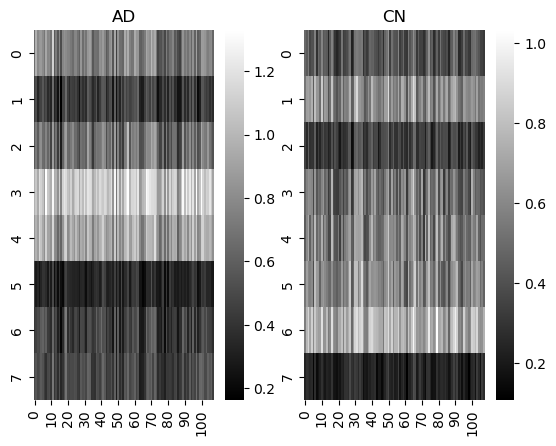

In [202]:
fig, axes = plt.subplots(ncols=2)

sns.heatmap(te_map, cmap='gray', ax=axes[0])
sns.heatmap(_te_map, cmap='gray', ax=axes[1])

axes[0].set_title("AD")
axes[1].set_title("CN")

<Axes: >

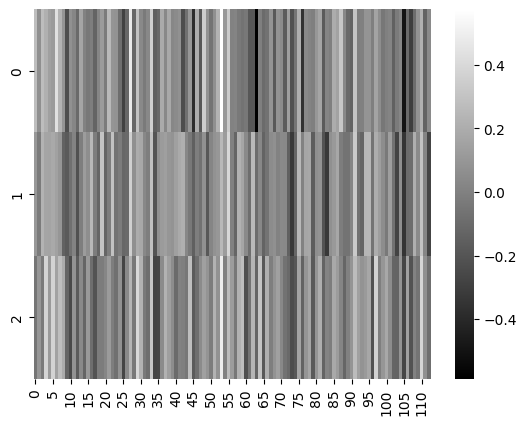

In [116]:
sns.heatmap(te_map_t.T, cmap='gray')

# FFT

In [118]:
d_max = 70
te_maps_delay = np.zeros((d_max, len(sig_rois), len(not_sig_rois)))
te_maps_t_delay = np.zeros((d_max, len(not_sig_rois), len(sig_rois)))
for d in range(1, d_max+1):
    print('d:', d)
    te_map = np.zeros((len(sig_rois), len(not_sig_rois)))
    te_map_t = np.zeros((len(sig_rois), len(not_sig_rois))).T
    for idx in range(len(not_sig_rois)): 
        i = not_sig_rois[idx]
        res = Parallel(n_jobs=20)(delayed(te.te_compute)(ad_ts_mean[i], ad_ts_mean[j], embedding=d) for j in sig_rois)
        te_map_t[idx] = res
    te_maps_t_delay[d-1] = te_map_t
    for idx in range(len(sig_rois)): 
        i = sig_rois[idx]
        res = Parallel(n_jobs=20)(delayed(te.te_compute)(ad_ts_mean[i], ad_ts_mean[j], embedding=d) for j in not_sig_rois)
        te_map[idx] = res
    te_maps_delay[d-1] = te_map


d: 1


/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython i

d: 2
d: 3
d: 4
d: 5
d: 6
d: 7
d: 8
d: 9
d: 10
d: 11
d: 12
d: 13
d: 14
d: 15
d: 16
d: 17
d: 18
d: 19
d: 20
d: 21
d: 22
d: 23
d: 24
d: 25
d: 26
d: 27
d: 28
d: 29
d: 30
d: 31
d: 32
d: 33
d: 34
d: 35
d: 36
d: 37
d: 38
d: 39
d: 40
d: 41
d: 42
d: 43
d: 44
d: 45
d: 46
d: 47
d: 48
d: 49
d: 50
d: 51
d: 52
d: 53
d: 54
d: 55
d: 56
d: 57
d: 58
d: 59
d: 60
d: 61
d: 62
d: 63
d: 64
d: 65
d: 66
d: 67
d: 68
d: 69
d: 70


ValueError: cannot call `vectorize` on size 0 inputs unless `otypes` is set

In [122]:
te_maps_delay = te_maps_delay[:d_max]
te_maps_t_delay = te_maps_t_delay[:d_max]

NameError: name 'd_max' is not defined

In [138]:
np.save('results/te_maps_delay', te_maps_delay)
np.save('results/te_maps_t_delay', te_maps_t_delay)


In [140]:
te_maps_delay = np.load('results/te_maps_delay.npy')
te_maps_t_delay = np.load('results/te_maps_t_delay.npy')

(70, 3, 113) (120, 113, 3)


In [126]:
fft_data = np.fft.fftn(te_maps_delay)

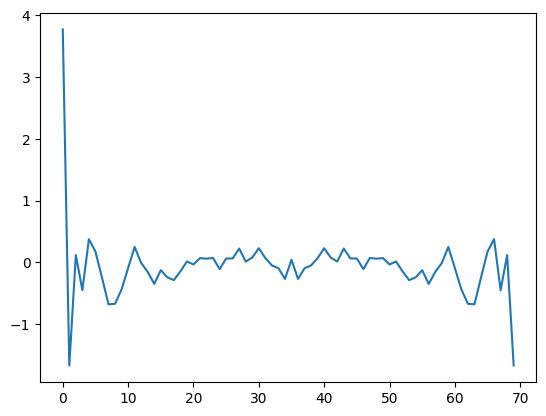

In [135]:
fft_data_mean = np.mean(fft_data.reshape(70, -1), axis=1)
plt.plot(np.real(fft_data_mean))

## Parcellation